In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing

In [22]:
train = pd.read_csv('TrainingData.txt')
test = pd.read_csv('TestingData.txt')
print(train)
print(test)

             t         tf0         ts0
0         0.00  873.000000  293.000000
1      2478.06  873.000000  655.920736
2      4956.12  873.000000  792.106226
3      7434.18  873.000000  842.176577
4      9912.24  873.000000  861.040655
..         ...         ...         ...
205  508002.30  730.794575  730.514961
206  510480.36  730.053663  729.797475
207  512958.42  729.371039  729.133162
208  515436.48  728.734400  728.511278
209  517914.54  728.135229  727.924326

[210 rows x 3 columns]
            t
0   520392.60
1   522870.66
2   525348.72
3   527826.78
4   530304.84
5   532782.90
6   535260.96
7   537739.02
8   540217.08
9   542695.14
10  545173.20
11  547651.26
12  550129.32
13  552607.38
14  555085.44
15  557563.50
16  560041.56
17  562519.62
18  564997.68
19  567475.74
20  569953.80
21  572431.86
22  574909.92
23  577387.98
24  579866.04
25  582344.10
26  584822.16
27  587300.22
28  589778.28
29  592256.34
30  594734.40
31  597212.46
32  599690.52
33  602168.58


In [23]:
def set_up_train_df(tf0,window):
    train_df = pd.DataFrame()
    if tf0:
        for i in range(window):
            train_df["timestep_{}".format(i+1)] = np.array(train['tf0'][i:len(train)-window+i])
        train_df['tf0'] = np.array(train['tf0'][window:len(train)]) 
    else:
        for i in range(window):
            train_df["timestep_{}".format(i+1)] = np.array(train['ts0'][i:len(train)-window+i])
        train_df['ts0'] = np.array(train['ts0'][window:len(train)]) 
    return train_df

In [24]:
train_tf = set_up_train_df(True, 70)
train_ts = set_up_train_df(False, 70)

In [25]:
scaler_tf = preprocessing.StandardScaler().fit(train_tf)
train_tf_transformed = scaler_tf.transform(train_tf)

scaler_ts = preprocessing.StandardScaler().fit(train_ts)
train_ts_transformed = scaler_ts.transform(train_ts)

In [26]:
batch_size = 50
training_set_tf_out = DataLoader(torch.utils.data.TensorDataset(torch.from_numpy(train_tf_transformed[:, :70]).float(), torch.from_numpy(train_tf_transformed[:, 70])), batch_size=batch_size, shuffle=False)
training_set_ts_out = DataLoader(torch.utils.data.TensorDataset(torch.from_numpy(train_ts_transformed[:, :70]).float(), torch.from_numpy(train_ts_transformed[:, 70])), batch_size=batch_size, shuffle=False)

In [27]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons, regularization_param, regularization_exp):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = nn.Tanh()
        self.regularization_param = regularization_param
        # Regularization exponent
        self.regularization_exp = regularization_exp
        # Random seed for weight initialization

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers-1)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)
        #self.retrain_seed = retrain_seed
        # Random Seed for weight initialization
        self.init_xavier()

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)

    def init_xavier(self):
        #torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                # torch.nn.init.xavier_normal_(m.weight, gain=g)
                m.bias.data.fill_(0)

        self.apply(init_weights)

    def regularization(self):
        reg_loss = 0
        for name, param in self.named_parameters():
            if 'weight' in name:
                reg_loss = reg_loss + torch.norm(param, self.regularization_exp)
        return self.regularization_param * reg_loss



In [28]:
network_tf_out = NeuralNet(input_dimension=70, 
                      output_dimension=1, 
                      n_hidden_layers=4, 
                      neurons=30,
                      regularization_param=0.0, 
                      regularization_exp=2)
network_ts_out = NeuralNet(input_dimension=70, 
                      output_dimension=1, 
                      n_hidden_layers=4, 
                      neurons=30,
                      regularization_param=0.0, 
                      regularization_exp=2)

In [29]:
optimizer_tf = optim.Adam(network_tf_out.parameters(), lr=0.001, weight_decay=5e-5)
optimizer_ts = optim.Adam(network_ts_out.parameters(), lr=0.001, weight_decay=5e-5)

In [30]:
def fit(model, training_set, num_epochs, optimizer, p, verbose=True):
    history = list()
    
    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])
        
        # Loop over batches
        for j, (x_train_, u_train_) in enumerate(training_set):  
            
            def closure():
                
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                u_pred_ = model(x_train_)
                # Item 1. above
                loss = torch.mean((u_pred_.reshape(-1, ) - u_train_.reshape(-1, ))**p)
                # Item 2. above
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                #for param in model.parameters():
                #    print(param.shape)
                #    print(param.grad)
                return loss
            
            # Item 3. above
            optimizer.step(closure=closure)
            
        if verbose: print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history

In [31]:
n_epochs = 3000
history_tf = fit(network_tf_out, training_set_tf_out, n_epochs, optimizer_tf, p=2)
history_ts = fit(network_ts_out, training_set_ts_out, n_epochs, optimizer_ts, p=2)

################################  0  ################################
Loss:  1.7956771644458758
################################  1  ################################
Loss:  0.7934468495190684
################################  2  ################################
Loss:  0.48795856488742456
################################  3  ################################
Loss:  0.3066390281593695
################################  4  ################################
Loss:  0.20176406813547962
################################  5  ################################
Loss:  0.16244978953889647
################################  6  ################################
Loss:  0.1359166675597492
################################  7  ################################
Loss:  0.10322250424889985
################################  8  ################################
Loss:  0.07656200144529471
################################  9  ################################
Loss:  0.06162245707814243
################################  

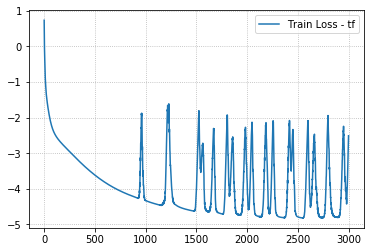

In [32]:
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1,n_epochs+1), np.log10(history_tf), label="Train Loss - tf")
plt.legend()

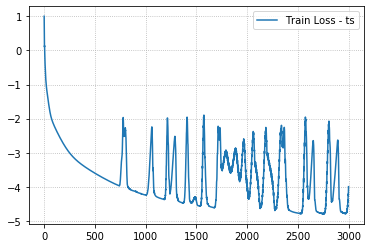

In [33]:
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1,n_epochs+1), np.log10(history_ts), label="Train Loss - ts")
plt.legend()

In [34]:
prediciton_tf_out_range = pd.DataFrame(np.append(train_tf_transformed[-1, 1:], 0).reshape(1,-1), columns=train_tf.columns)
prediciton_tf_out_range['tf0'][0] = network_tf_out(torch.from_numpy(np.array(prediciton_tf_out_range.iloc[0,:70])).float()).detach().numpy()[0]
prediciton_tf_out_range

prediciton_ts_out_range = pd.DataFrame(np.append(train_ts_transformed[-1, 1:], 0).reshape(1,-1), columns=train_ts.columns)
prediciton_ts_out_range['ts0'][0] = network_ts_out(torch.from_numpy(np.array(prediciton_ts_out_range.iloc[0,:70])).float()).detach().numpy()[0]
prediciton_ts_out_range

,timestep_1,timestep_2,timestep_3,timestep_4,timestep_5,timestep_6,timestep_7,timestep_8,timestep_9,timestep_10,...,timestep_62,timestep_63,timestep_64,timestep_65,timestep_66,timestep_67,timestep_68,timestep_69,timestep_70,ts0
0,-0.254369,0.399045,0.636829,0.725222,0.758897,0.771977,0.777135,0.779196,0.780027,0.780242,...,-0.922605,-0.994878,-1.031374,-1.064701,-1.097927,-1.131637,-1.166132,-1.201654,-1.23842,-0.172459


In [35]:
for i in range(1, len(test)):
    new_pred = network_tf_out(torch.from_numpy(np.array(prediciton_tf_out_range.iloc[i-1,1:])).float()).detach().numpy()[0]
    prediciton_tf_out_range.loc[i] = np.append(np.array(prediciton_tf_out_range.iloc[i-1,1:]), new_pred)
prediciton_tf_out_range

for i in range(1, len(test)):
    new_pred = network_ts_out(torch.from_numpy(np.array(prediciton_ts_out_range.iloc[i-1,1:])).float()).detach().numpy()[0]
    prediciton_ts_out_range.loc[i] = np.append(np.array(prediciton_ts_out_range.iloc[i-1,1:]), new_pred)
prediciton_ts_out_range

,timestep_1,timestep_2,timestep_3,timestep_4,timestep_5,timestep_6,timestep_7,timestep_8,timestep_9,timestep_10,...,timestep_62,timestep_63,timestep_64,timestep_65,timestep_66,timestep_67,timestep_68,timestep_69,timestep_70,ts0
0,-0.254369,0.399045,0.636829,0.725222,0.758897,0.771977,0.777135,0.779196,0.780027,0.780242,...,-0.922605,-0.994878,-1.031374,-1.064701,-1.097927,-1.131637,-1.166132,-1.201654,-1.238420,-0.172459
1,0.399045,0.636829,0.725222,0.758897,0.771977,0.777135,0.779196,0.780027,0.780242,0.780214,...,-0.994878,-1.031374,-1.064701,-1.097927,-1.131637,-1.166132,-1.201654,-1.238420,-0.172459,0.419880
2,0.636829,0.725222,0.758897,0.771977,0.777135,0.779196,0.780027,0.780242,0.780214,0.780164,...,-1.031374,-1.064701,-1.097927,-1.131637,-1.166132,-1.201654,-1.238420,-0.172459,0.419880,0.673429
3,0.725222,0.758897,0.771977,0.777135,0.779196,0.780027,0.780242,0.780214,0.780164,0.780113,...,-1.064701,-1.097927,-1.131637,-1.166132,-1.201654,-1.238420,-0.172459,0.419880,0.673429,0.722882
4,0.758897,0.771977,0.777135,0.779196,0.780027,0.780242,0.780214,0.780164,0.780113,0.780061,...,-1.097927,-1.131637,-1.166132,-1.201654,-1.238420,-0.172459,0.419880,0.673429,0.722882,0.776399
5,0.771977,0.777135,0.779196,0.780027,0.780242,0.780214,0.780164,0.780113,0.780061,0.780008,...,-1.131637,-1.166132,-1.201654,-1.238420,-0.172459,0.419880,0.673429,0.722882,0.776399,0.785791
6,0.777135,0.779196,0.780027,0.780242,0.780214,0.780164,0.780113,0.780061,0.780008,0.779953,...,-1.166132,-1.201654,-1.238420,-0.172459,0.419880,0.673429,0.722882,0.776399,0.785791,0.781868
7,0.779196,0.780027,0.780242,0.780214,0.780164,0.780113,0.780061,0.780008,0.779953,0.779898,...,-1.201654,-1.238420,-0.172459,0.419880,0.673429,0.722882,0.776399,0.785791,0.781868,0.801679
8,0.780027,0.780242,0.780214,0.780164,0.780113,0.780061,0.780008,0.779953,0.779898,0.779831,...,-1.238420,-0.172459,0.419880,0.673429,0.722882,0.776399,0.785791,0.781868,0.801679,0.813271
9,0.780242,0.780214,0.780164,0.780113,0.780061,0.780008,0.779953,0.779898,0.779831,0.775473,...,-0.172459,0.419880,0.673429,0.722882,0.776399,0.785791,0.781868,0.801679,0.813271,0.825397


In [36]:
pred_tf = scaler_tf.inverse_transform(prediciton_tf_out_range)
pred_ts = scaler_ts.inverse_transform(prediciton_ts_out_range)

In [37]:
total_pred = pd.DataFrame({'t':list(test['t']), 'tf0':pred_tf[:, -1], 'ts0': pred_ts[:, -1]})

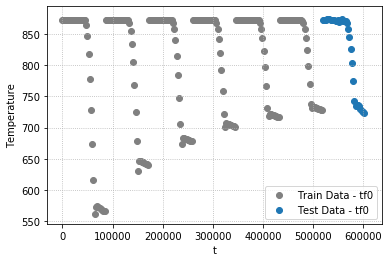

In [38]:
plt.grid(True, which="both", ls=":")
plt.scatter(train['t'], train['tf0'], label="Train Data - tf0", marker="o", color="grey")
plt.scatter(total_pred['t'], total_pred['tf0'], label="Test Data - tf0", marker="o")
plt.xlabel("t")
plt.ylabel("Temperature")
plt.legend()

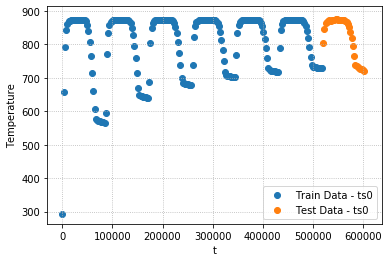

In [39]:
plt.grid(True, which="both", ls=":")
plt.scatter(train['t'], train['ts0'], label="Train Data - ts0")
plt.scatter(total_pred['t'], total_pred['ts0'], label="Test Data - ts0")
plt.xlabel("t")
plt.ylabel("Temperature")
plt.legend()

In [43]:
print(total_pred["t"])
print(total_pred["t"].shape)
print(total_pred["tf0"].shape)
print(total_pred["ts0"].shape)

0     520392.60
1     522870.66
2     525348.72
3     527826.78
4     530304.84
5     532782.90
6     535260.96
7     537739.02
8     540217.08
9     542695.14
10    545173.20
11    547651.26
12    550129.32
13    552607.38
14    555085.44
15    557563.50
16    560041.56
17    562519.62
18    564997.68
19    567475.74
20    569953.80
21    572431.86
22    574909.92
23    577387.98
24    579866.04
25    582344.10
26    584822.16
27    587300.22
28    589778.28
29    592256.34
30    594734.40
31    597212.46
32    599690.52
33    602168.58
Name: t, dtype: float64
(34,)
(34,)
(34,)


In [44]:
type(total_pred["t"])

pandas.core.series.Series

In [55]:
total_pred_t = total_pred["t"].values
total_pred_tf = total_pred["tf0"].values
total_pred_ts = total_pred["ts0"].values

In [67]:
total_output = np.append(total_pred_t.reshape(-1,1), total_pred_tf.reshape(-1,1), axis=1)
total_output = np.append(total_output, total_pred_ts.reshape(-1,1),axis=1)
total_output = pd.DataFrame(total_output)

In [68]:
headerlist = ["t", "tf0", "ts0"]
total_output.to_csv("Task3.txt", header = headerlist, index=False, sep=",", mode="w")